In [1]:
cd /home/edrewke/FHDeX/exec/immersed_boundary/flagellum/

[Errno 2] No such file or directory: '/home/edrewke/FHDeX/exec/immersed_boundary/flagellum/'
/home/jblaschke/FHDeX/exec/immersed_boundary/flagellum


In [1]:
import sys, os, os.path
import glob

import scipy as sp
import numpy as np

import matplotlib
import matplotlib.pyplot as pp

import yt
from yt.frontends.boxlib.data_structures import AMReXDataset

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.append("../src_analysis")
from data_model import *
from visualize  import *

In [4]:
sys.path.append("/home/jblaschke/chlamy-flagellum")
import pychlamy.data_model       as cdm
from   pychlamy.geometry         import DiscreteCurve
from   pychlamy.fourier_analysis import FourierTransform
from   scipy.io                  import loadmat

In [5]:
data_root = "."
data_dir  = "."

In [6]:
data_path = os.path.join(data_root, data_dir)

In [7]:
n_fill   = 5
prefix   = "plt"
file_fmt = prefix + "{:0" + str(n_fill) + "d}"

In [8]:
data_glob  = os.path.join(data_path, prefix + "*")
data_files = glob.glob(data_glob)
data_files.sort()
#print(data_files)
len(data_files)

623

In [9]:
data_raw = loadmat(os.path.join("/home/jblaschke/chlamy-flagellum/original_data","WT63test4.mat"))
data     = cdm.SoA(data_raw)
dc       = DiscreteCurve(data, 21)

In [10]:
fft_nodes = [None]*dc.length_angles()
fft = FourierTransform(dc, stride=1)
for i_node in range(dc.length_angles()):
    fft_nodes[i_node] = fft.fft_angle(i_node)

In [11]:
theta_nodes = lambda t: np.array([node.eval(t, 4) for node in fft_nodes])

In [12]:
dt          = 1e-5
plot_int    = 200
frequency   = .1
len(data_files)*plot_int*dt

1.246

In [29]:
def rotate(tx, ty, theta):
    ct = np.cos(theta)
    st = np.sin(theta)
    
    rx = ct*tx - st*ty
    ry = st*tx + ct*ty
    
    return rx, ry

def next_node(px, py, tx, ty, ds):
    return px + tx*ds, py + ty*ds

def generate_curve(x0, y0, ds, theta):
    x = np.zeros(len(theta)+1)
    y = np.zeros(len(theta)+1)

    # first angle is the ancoring angle:
    tx = np.cos(theta[0])
    ty = np.sin(theta[0])

    x[0] = x0
    y[0] = y0

    for i in range(1, len(theta)):
        x[i], y[i] = next_node(x[i-1], y[i-1], tx, ty, ds)
        tx,   ty   = rotate(tx, ty, theta[i])

    # last node
    x[-1], y[-1] = next_node(x[-2], y[-2], tx, ty, ds)

    return x, y

def add_equilibrium(slc, dc, theta_nodes, data_files, plot_index, dt, plot_int, frequency, prop):
    amrex_ds = AMReXDataset(data_files[plot_index])
    ad = amrex_ds.all_data()
    aos = AoS(ad, copy_id=True)
    
    t = plot_index*frequency*plot_int*dt
    
    theta = theta_nodes(t)
    
    x0, y0, z0, x1, y1, z1 = [None]*6
    for p in aos.particles:
        print(p.id, p.cpu)
        if p.id == 0:
            x0, y0, z0 = aos.particles[0].pos[:]
        elif p.id == 1:
            x1, y1, z1 = aos.particles[1].pos[:]
    
    ds = (x1-x0)
    x_pred, y_pred = generate_curve(x1, y1, ds, theta)
    # add first marker to list
    x = np.concatenate((np.array([x0]), x_pred))
    y = np.concatenate((np.array([y0]), y_pred))
    
    for j, p in enumerate(zip(x, y, np.ones_like(x)*z0)):
        slc.annotate_sphere(p, radius=prop.marker_rad, circle_args={'fill':True, 'color':'white'})
        slc.annotate_sphere(p, radius=prop.marker_rad*0.7, circle_args={'fill':True, 'color':'black'})
    
    return slc

In [30]:
# don't use `plot_index = -1` here because this would get the equilibrium 
# configuration's time wrong
plot_index = len(data_files)-1

# set up plot
prop = PlotProperies(marker_rad=5e-5, slc_name="pres", slc_max=2e-2)

# load data
ds = yt.load(data_files[plot_index])

# plot everything
slc  = slice_plt(ds, prop)
add_ibm(slc, data_files[plot_index], prop)
add_equilibrium(slc, dc, theta_nodes, data_files, plot_index, dt, plot_int, frequency, prop)
slc.show()

2 3
1 3
15 3
14 3
1 2
2 2
3 2
4 2
5 2
6 2
7 2
3 3
4 3
5 3
6 3
13 3
10 3
12 3
11 3
7 3
8 3
9 3


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [15]:
amrex_ds = AMReXDataset(data_files[plot_index])
ad = amrex_ds.all_data()
aos = AoS(ad, copy_id=True)

In [18]:
aos.particles[0].id

2

In [15]:
for i, data_file in enumerate(data_files):
    frame_file = "frame_" + str(i).zfill(5) + ".png"

    if os.path.isfile(frame_file):
        continue
    else:
        print(f"Working on: {frame_file}", end="\r")

    # load data
    ds = yt.load(data_file)

    # plot everything
    slc  = slice_plt(ds, prop)
    add_ibm(slc, data_file, prop)
    add_equilibrium(slc, dc, theta_nodes, data_files, i, dt, plot_int, frequency, prop)

    slc.save(frame_file)

In [64]:
yt.funcs.mylog.setLevel(50)

avg_pos_x = list()
avg_pos_y = list()

for i, data_file in enumerate(data_files[::5]):
    ds = yt.load(data_file)
    
    amrex_ds = AMReXDataset(data_file)
    ad = amrex_ds.all_data()
    aos = AoS(ad)
    
    p_x = 0
    p_y = 0
    n = 0
    
    for j, part in enumerate(aos.particles[::n_marker_skip]):
        p_x += part.pos[0]
        p_y += part.pos[1]
        n += 1

    avg_pos_x.append(p_x/n)
    avg_pos_y.append(p_y/n)

NameError: name 'n_marker_skip' is not defined

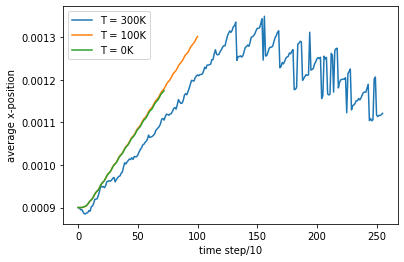

In [2061]:
plot(avg_pos_x, label = "T = 300K")
plot(avg_pos_x_highres_lofluct, label = "T = 100K")
plot(avg_pos_x_highres_nofluct, label = "T = 0K")

#plot(avg_pos_x_highres_sparse)
#plot(avg_pos_x_highres, label = "$\mathrm{d}x = h/2$")
#plot(avg_pos_x_lowres,  label = "$\mathrm{d}x = h$")
xlabel("time step/10")
ylabel("average x-position")
legend();

#savefig("xvst.pdf")

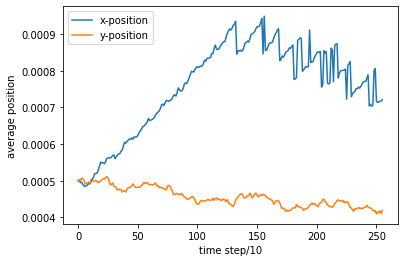

In [2062]:
plot(np.array(avg_pos_x)-0.0004, label = "x-position")
plot(np.array(avg_pos_y), label = "y-position")

xlabel("time step/10")
ylabel("average position")
#grid()
legend();

#savefig("xyvst.pdf")

In [1824]:
#avg_pos_x_highres_lofluct = avg_pos_x
#avg_pos_x_highres_nofluct = avg_pos_x
#avg_pos_x_highres_sparse = avg_pos_x
#avg_pos_x_highres_slow = avg_pos_x
#avg_pos_x_highres = avg_pos_x
#avg_pos_x_lowres = avg_pos_x

In [891]:
ds.field_list

[('boxlib', 'averaged_velx'),
 ('boxlib', 'averaged_vely'),
 ('boxlib', 'averaged_velz'),
 ('boxlib', 'divergence'),
 ('boxlib', 'pres'),
 ('boxlib', 'shifted_velx'),
 ('boxlib', 'shifted_vely'),
 ('boxlib', 'shifted_velz'),
 ('boxlib', 'tracer')]

In [31]:
ds.particle_field_by_type


AttributeError: 'BoxlibDataset' object has no attribute 'particle_field_by_type'

In [ ]:
ad = ds.all_data()
aos = AoS(ad)

In [ ]:
for i, part in enumerate(aos.particles):
    print(part.pos)

In [ ]:
p = aos.particles[1]


In [ ]:
p.annotate_sphere([0.5, 0.5, 0.5], radius=(2, 'kpc'),
                  circle_args={'color':'black'})

In [ ]:
p
